<center><h1 style="text-align: center;"><u>TFM - Detección temprana del cáncer a partir de los resultados de análisis de sangre</u></h1>
<center><h1 style="text-align: center;"><u>TFM - Contraste del modelo CancerA1DE para la detección prematura de cáncer frente a otros modelos de predicción</u></h1>
<center><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="Drawing" style="align=left"/>

# INTRODUCCIÓN

En este notebook se lleva a cabo el contraste del modelo CancerA1DE para la detección prematura de cáncer frente a otros modelos de predicción.

El artículo sobre el que se basa esta investigación es "Early Cancer Detection from Multianalyte Blood Test Results" presente en : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6548890/

El contenido abarca un repaso de los datos, su análisis a todos los niveles y los diferentes enfoques para entrenar, validar y testear los distintos modelos.

Los datos se encontrarán en la siguiente ruta en local : C:\Users\danie\OneDrive\Documentos\Master\Lusku\TFM\Proposiciones\Deteccion Cancer\Datos

IMPORTANTE : Cada vez que tenga que rellenarse a mano el valor de una variable, se mostrará con : 

                    (I) Introducir valor de 'nombreDeLaVariable'

Para descargar las librerías usadas en este proyecto se puede hacer usar el comando "pip install -r requirements.txt" en el terminal

In [1]:
# Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import normaltest

# Entrenar el modelo
from sklearn.model_selection import train_test_split

# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer

In [2]:
# Carga de la URL de donde se encuentran los datos 
# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan los datos
nombreArchivo = 'Tables_S1_to_S11' #nombre del archivo del dataset
url_datos = f'C:/Users/danie/OneDrive/Documentos/Master/Lusku/TFM/Proposiciones/Deteccion Cancer/Datos/{nombreArchivo}.xlsx'

In [3]:
# Bucle for para generar los nombres de las hojas en excel que se van a recuperar
nombres_hojas = [] 
for i in range(1, 10):
    nombre_hoja = f'Table S{i}'
    nombres_hojas.append(nombre_hoja)

print(nombres_hojas)

['Table S1', 'Table S2', 'Table S3', 'Table S4', 'Table S5', 'Table S6', 'Table S7', 'Table S8', 'Table S9']


In [4]:
# Se procede a hacer una carga de los datos. Al haber varias hojas en el excel, se cargan las que pasemos como parámetro en "nombres_hojas"
df_dict= pd.read_excel(url_datos, sheet_name=nombres_hojas)

## print(df_dict.items())
print(range(1,len(nombres_hojas)+1))

range(1, 10)


In [5]:
# [CLAVE]
# Itera sobre las hojas en el diccionario y va creando un dataFrame para cada hoja del excel cargada
for indice, (nombre_hoja, dataframe) in enumerate(df_dict.items(), start=1):
    # Creamos el nombre de la variable para el DataFrame
    nombre_variable = f"df{indice}"
    print(nombre_variable)
    # Creamos una variable con el nombre de la variable para el DataFrame y asignamos el DataFrame a esa variable
    globals()[nombre_variable] = dataframe
# se crean variables df1, df2, ... para cada uno de los dataFrames del diccionario
print(globals())

df1
df2
df3
df4
df5
df6
df7
df8
df9
{'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', '# Carga de librerias\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nfrom scipy.stats import skew, kurtosis\nfrom scipy.stats import shapiro\nfrom scipy.stats import normaltest\n\n# Entrenar el modelo\nfrom sklearn.model_selection import train_test_split\n\n# Selección de las variables por tipo\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import StandardScaler, OneHotEncoder\nfrom sklearn.compose import make_column_selector\nfrom sklearn.impute import SimpleImputer', "# Carga de la URL de donde se encuentran los datos \n# (I) Introducir valor de nombreArchivo y variar la ruta en local donde se guardan lo

# 1. ANÁLISIS GENERAL DE LOS DATOS

In [7]:
# (I) Ejecutar 2 veces, la primera falla.
# Visualizar información de cada dataFrame
# Creamos una lista para almacenar las variables que son DataFrames
dataframes_globales = []
# Creamos una copia del diccionario globals()
globals_copy = globals()

# Iteramos sobre las variables globales y almacenamos las que son DataFrames en la lista
for nombre_variable, valor_variable in globals_copy.items():
    # Verificamos si la variable es un DataFrame
    if isinstance(valor_variable, pd.DataFrame):
        # Agregamos la variable a la lista
        dataframes_globales.append((nombre_variable, valor_variable))

# Iteramos sobre la lista de DataFrames e imprimimos la información de cada uno
for nombre_variable, valor_variable in dataframes_globales:
    if nombre_variable.startswith('df'):
        print("\tInformación del data frame " + nombre_variable + ":\n")
        print(valor_variable.info())
        print("\n")

	Información del data frame df1:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Amplicon Name                              61 non-null     object
 1   Amplicon-specific forward primer sequence  61 non-null     object
 2   Amplicon-specific reverse primer sequence  61 non-null     object
 3   Gene                                       61 non-null     object
 4   Genomic coordinates of amplified region*   61 non-null     object
 5   Region of interest length (bp)             61 non-null     int64 
 6   Amplicon length (bp)                       61 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 3.5+ KB
None


	Información del data frame df2:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 6 columns):
 #   Column                 

In [8]:
# Iteramos sobre la lista de DataFrames e imprimimos su nombre y el shape
for nombre_variable, valor_variable in dataframes_globales:
    if nombre_variable.startswith('df') :
        print(f"Variable: {nombre_variable}, Shape: {valor_variable.shape}")

Variable: df1, Shape: (61, 7)
Variable: df2, Shape: (1024, 6)
Variable: df3, Shape: (41, 4)
Variable: df4, Shape: (1817, 13)
Variable: df5, Shape: (1817, 12)
Variable: df6, Shape: (1817, 45)
Variable: df7, Shape: (153, 11)
Variable: df8, Shape: (626, 12)
Variable: df9, Shape: (9, 3)


In [9]:
print(df6.dtypes)

Patient ID #                             object
Sample ID #                              object
Tumor type                               object
AJCC Stage                               object
AFP (pg/ml)                              object
Angiopoietin-2 (pg/ml)                   object
AXL (pg/ml)                             float64
CA-125 (U/ml)                            object
CA 15-3 (U/ml)                           object
CA19-9 (U/ml)                            object
CD44 (ng/ml)                             object
CEA (pg/ml)                              object
CYFRA 21-1 (pg/ml)                       object
DKK1 (ng/ml)                             object
Endoglin (pg/ml)                         object
FGF2 (pg/ml)                             object
Follistatin (pg/ml)                      object
Galectin-3 (ng/ml)                       object
G-CSF (pg/ml)                            object
GDF15 (ng/ml)                            object
HE4 (pg/ml)                             

In [17]:
df6.head()

,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,CRC 455,CRC 455 PLS 1,Colorectum,I,1583.45,5598.5,3621.04,5.09,19.08,*16.452,...,*204.792,55.06,6832.07,9368.53,*16.086,21863.74,56428.71,39498.82,0.938342,Positive
1,CRC 456,CRC 456 PLS 1,Colorectum,I,*715.308,20936.35,2772.96,7.27,10.04,40.91,...,*204.792,72.92,5549.47,6224.55,*16.086,29669.66,73940.49,41277.09,0.925363,Positive
2,CRC 457,CRC 457 PLS 1,Colorectum,II,4365.53,2350.93,4120.77,*4.854,16.96,*16.452,...,*204.792,173.78,3698.16,4046.48,179.03,6020.47,22797.28,28440.60,0.852367,Negative
3,CRC 458,CRC 458 PLS 1,Colorectum,II,*715.308,1604.34,2029.96,5.39,8.31,*16.452,...,*204.792,29.47,5856,6121.93,*16.086,4331.02,20441.19,25896.73,0.617639,Negative
4,CRC 459,CRC 459 PLS 1,Colorectum,II,801.3,2087.57,2069.17,*4.854,11.73,*16.452,...,*204.792,78.07,5447.93,6982.32,*16.086,2311.91,56288.51,49425.20,0.318434,Negative


In [7]:
columns = df6.columns
columns

Index(['Amplicon Name', 'Amplicon-specific forward primer sequence',
       'Amplicon-specific reverse primer sequence', 'Gene',
       'Genomic coordinates of amplified region*',
       'Region of interest length (bp)', 'Amplicon length (bp)'],
      dtype='object')

In [10]:
# Verificar valores nulos para cada dataFrame
for nombre_variable, valor_variable in dataframes_globales:
    if nombre_variable.startswith('df') :
        print(f"\t Valores nulos para {nombre_variable} :\n{valor_variable.isnull().sum()}\n\n")

	 Valores nulos para df1 :
Amplicon Name                                0
Amplicon-specific forward primer sequence    0
Amplicon-specific reverse primer sequence    0
Gene                                         0
Genomic coordinates of amplified region*     0
Region of interest length (bp)               0
Amplicon length (bp)                         0
dtype: int64


	 Valores nulos para df2 :
Patient ID #                            0
Sample ID #                             0
Tumor type                              0
AJCC Stage                              0
Mutation identified in tumor tissue*    0
Mutant mean allele frequency (%)        0
dtype: int64


	 Valores nulos para df3 :
Protein                                0
Evaluated in this study                0
Included in CancerSEEK test            0
Used for cancer type identification    0
dtype: int64


	 Valores nulos para df4 :
Patient ID #                              0
Plasma sample ID #                        0
Primary tumor 

## 1.1 Visualización de los datos sin procesar

In [ ]:
# Verificar valores nulos con seaborn.heatmap() para cada dataFrame
for nombre_variable, valor_variable in dataframes_globales:
    if nombre_variable.startswith('df') :
        plt.figure(figsize=(24, 16))
        plt.title(f"HEATMAP de valores nulos para el dataFrame {nombre_variable}")
        sns.heatmap(valor_variable.isnull(), cbar=False, yticklabels=False,cmap='plasma')

Se observa que el "parámetro AJCC" stage posee para varías de las tablas valores nulos. En este caso no es una anomalía ya que describe la severidad del cáncer en base a la magnitud del cáncer original detectado. Por tanto, para personas del estudio libres de cáncer en un primer momento, la variable AJCC stage permanece sin valor. De igual manera ocurre para la variable "Histopatología" del data frame 4.

Para evitar la aparición de estos nulos controlados de las variables "parámetro AJCC" e "Histopatología", quizá se pueda considerar sustituirlos por valores consensuados.

Por otro lado, en los data frames 5 y 6, aparecen valores nulos de algunos de los parámetros de las analíticas. Estos nulos serán tratados en el apartado de limpieza de datos.

In [ ]:
# Visualización de la distribución de las variables numéricas
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df1
num_cols = dataFrame.select_dtypes(include=np.number).columns.tolist()
if num_cols :
    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.histplot(dataFrame[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()
else: print("No hay variables numéricas")

In [ ]:
# Visualización de la distribución de las variables categóricas [no es muy visual]
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df1
num_cols = dataFrame.select_dtypes(include='object').columns.tolist()
if len(num_cols) > 1:
    print("Distribución de las variables categóricas:")
    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.histplot(dataFrame[col], kde=True)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()
else :
    print("[ERROR] No hay suficientes variables categóricas para visualizar la distribución de los datos de las variables categóricas")

## 1.2 Correlaciones

In [26]:

# Función para convertir una matrix de correlación de pandas en formato tidy
def tidy_corr_matrix(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = df1.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix = tidy_corr_matrix(corr_matrix)
tidy_corr_matrix.head(20)


,variable_1,variable_2,r,abs_r
1,Region of interest length (bp),Amplicon length (bp),0.668027,0.668027
2,Amplicon length (bp),Region of interest length (bp),0.668027,0.668027


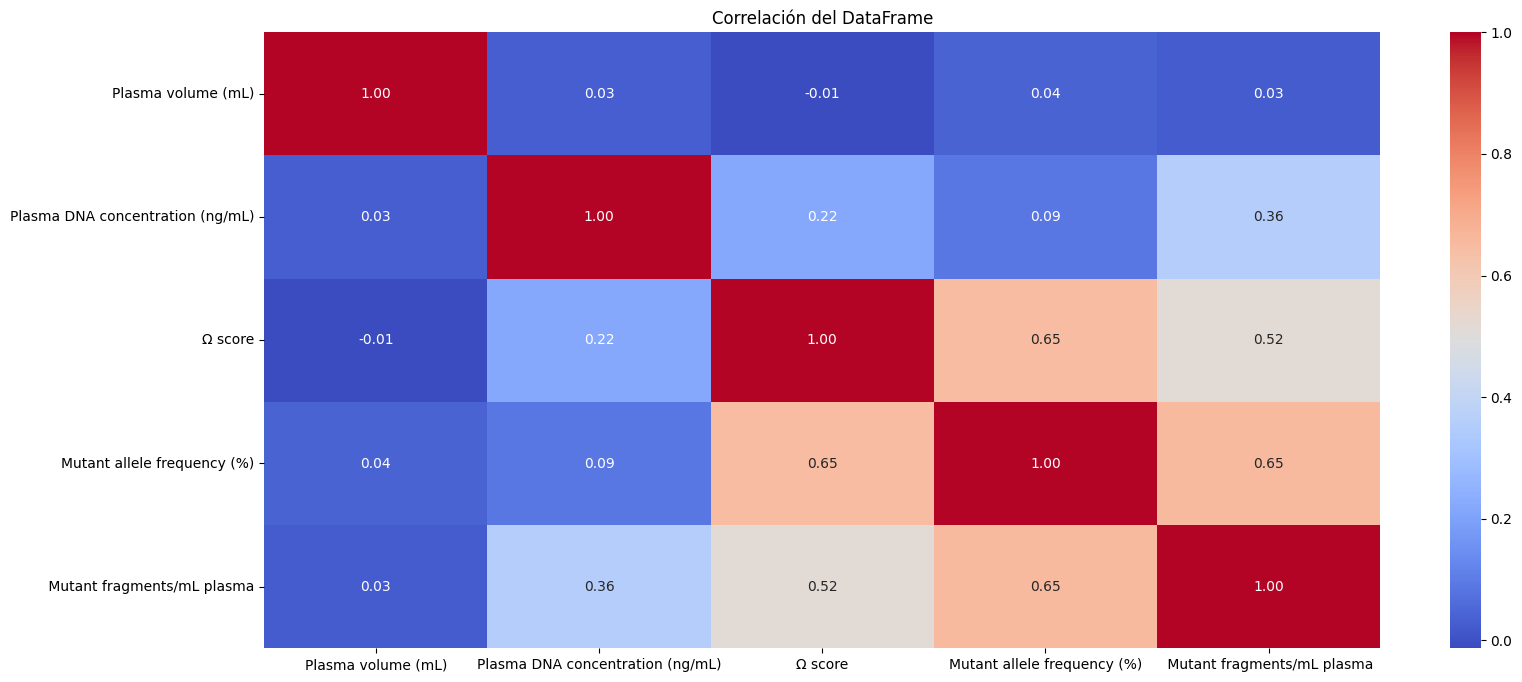

In [36]:

df1_numeric = df7.select_dtypes(include='number')

# Verificar si hay columnas numéricas para evitar el error
if not df1_numeric.empty:
    plt.figure(figsize=(18, 8))
    sns.heatmap(df1_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlación del DataFrame')
    plt.show()
else:
    print("No hay suficientes columnas numéricas para calcular la correlación.")

    '''
    # Visualización de la correlación GLOBAL de los datos del dataFrame
    correlation_matrix = df.corr()
    plt.figure(figsize=(24, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlación del DataFrame')
    plt.show()
    '''

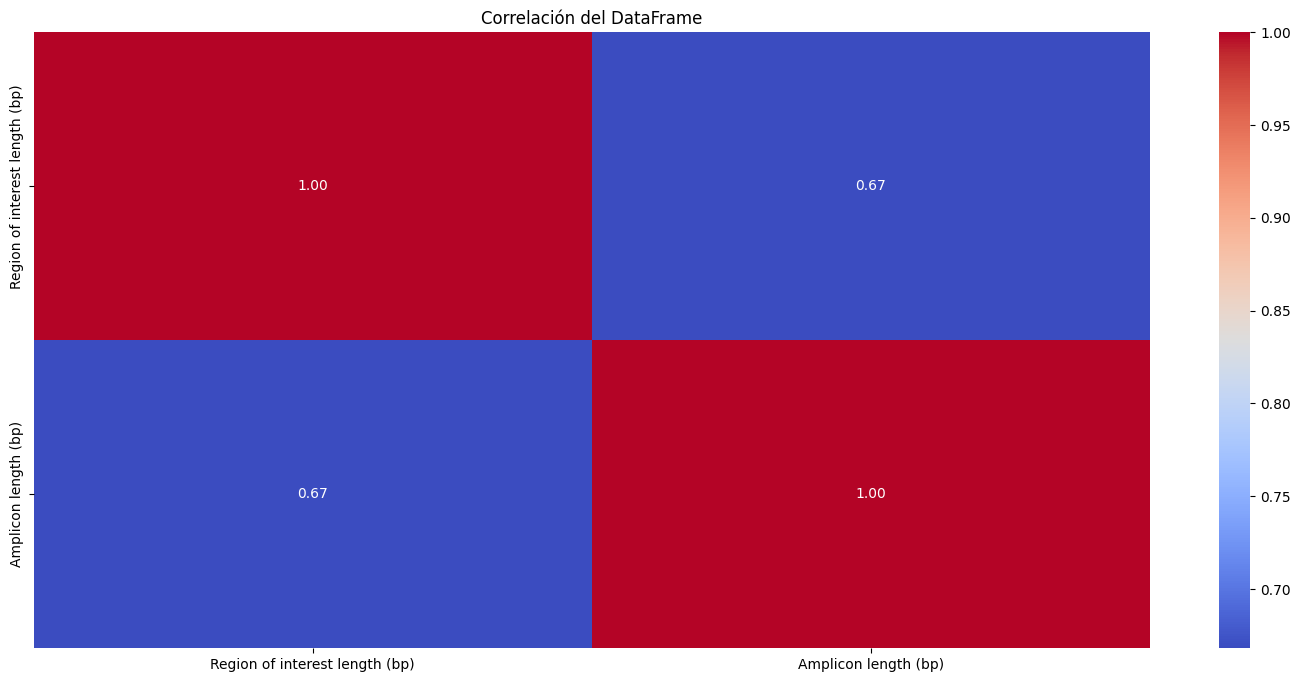

In [15]:
# Visualización de la correlación entre variables NUMÉRICAS
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df1
numeric_correlation_matrix = dataFrame.select_dtypes(include=np.number).corr()
plt.figure(figsize=(18, 8))
sns.heatmap(numeric_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación del DataFrame')
plt.show()


Correlación entre variables categóricas:


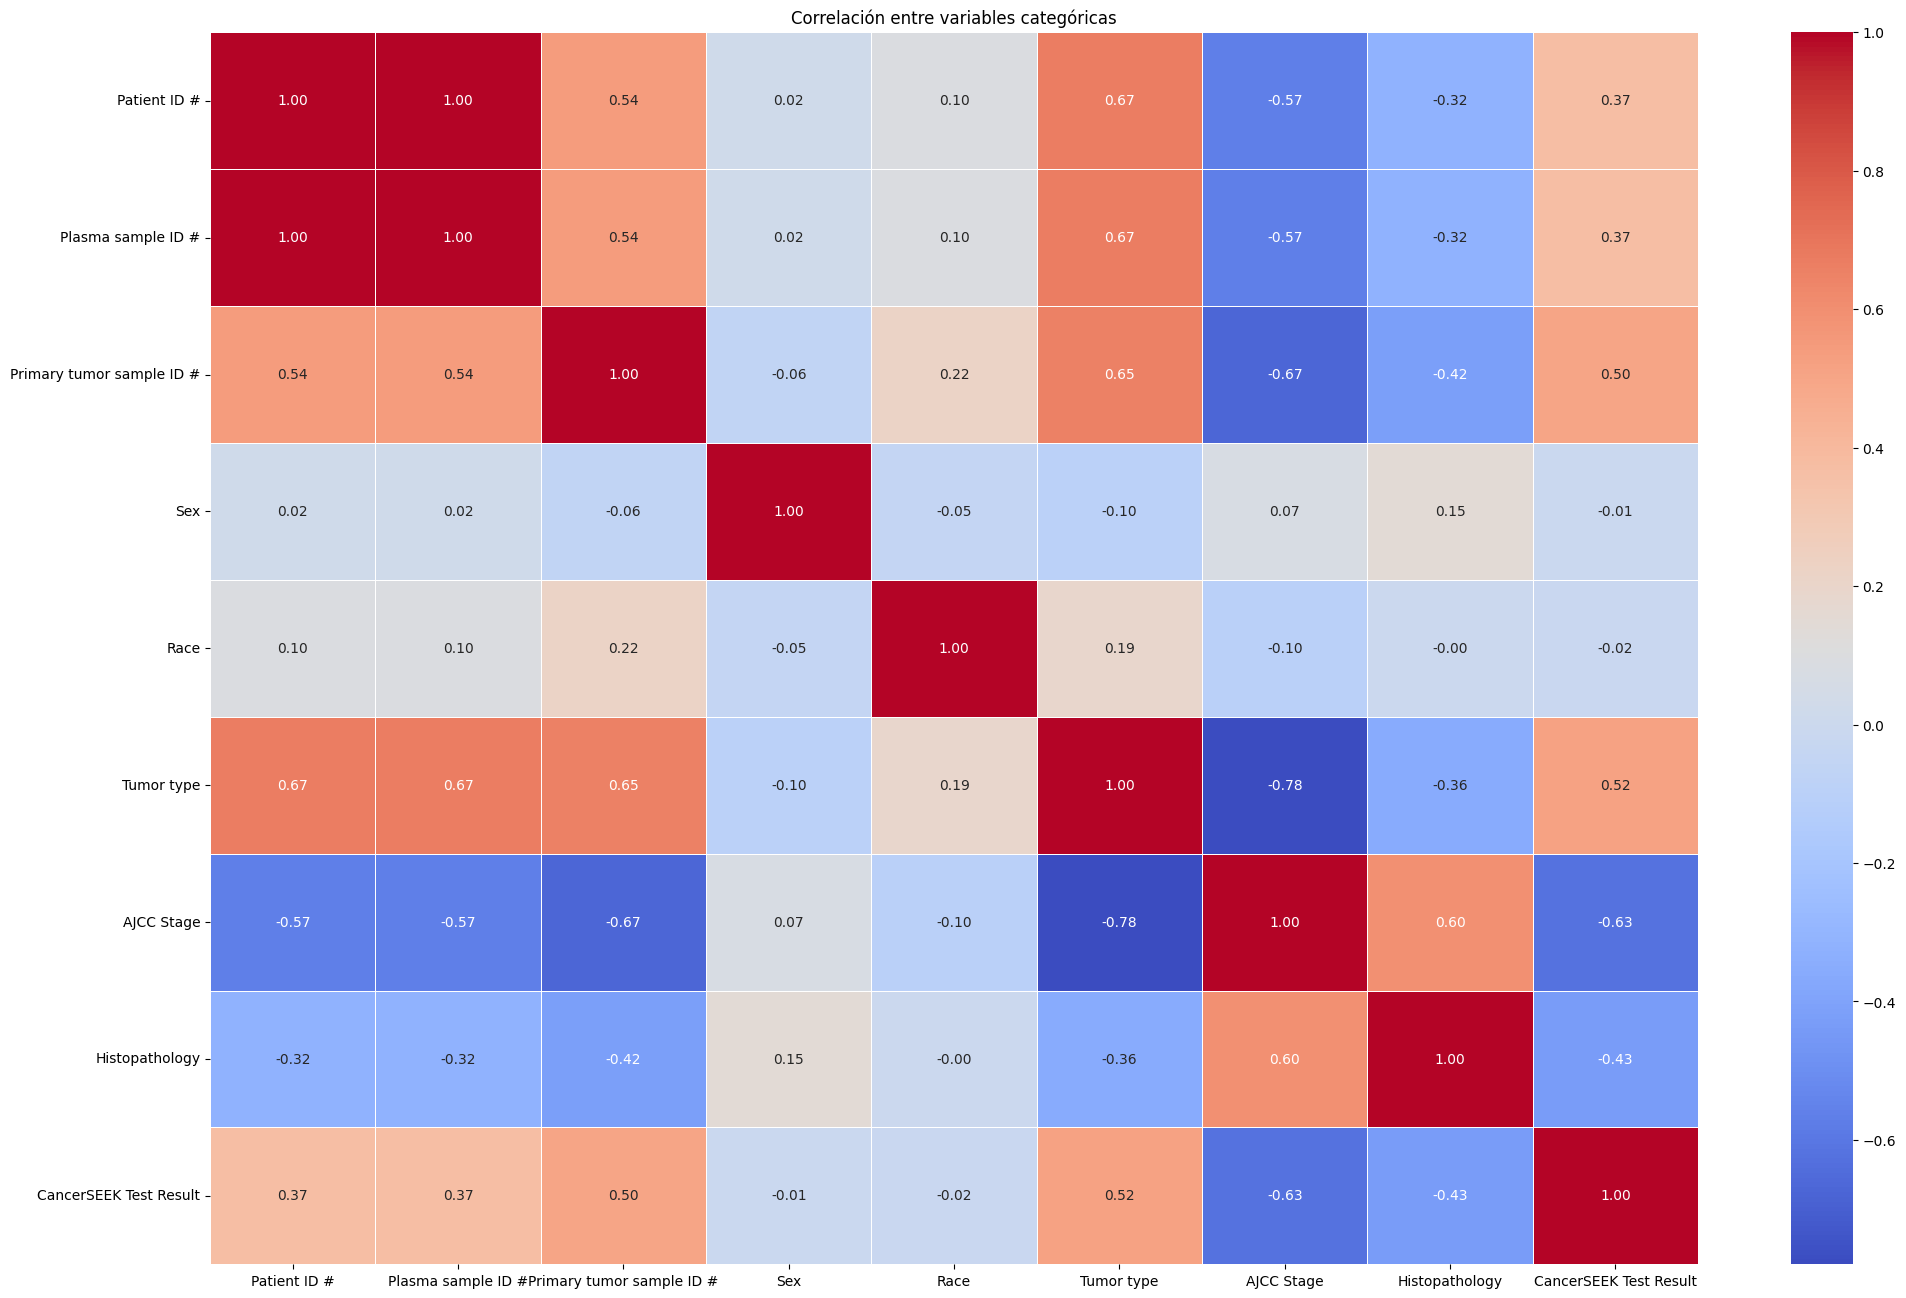

In [13]:
# Visualización de la correlación entre variables CATEGÓRICAS
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df4
print("Correlación entre variables categóricas:")
cat_cols = dataFrame.select_dtypes(include='object').columns.tolist()
if len(cat_cols) > 1:
    cat_corr_matrix = dataFrame[cat_cols].apply(lambda x: x.factorize()[0]).corr()
    plt.figure(figsize=(24, 16))
    sns.heatmap(cat_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlación entre variables categóricas")
    plt.show()
else:
    print("[ERROR] No hay suficientes variables categóricas para calcular la correlación.")


# 2. ANÁLISIS PROFUNDO DE LOS DATOS

Distribución de las variables numéricas:


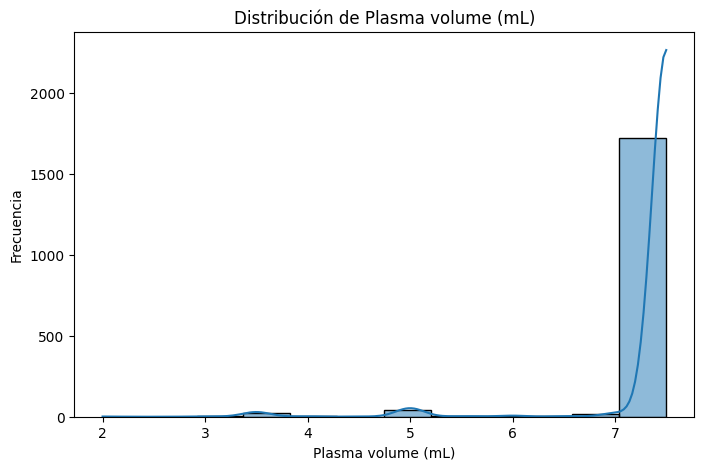

Asimetría de Plasma volume (mL): -5.142140594485198
Curtosis de Plasma volume (mL): 26.724590719246834


Prueba de Shapiro para Plasma volume (mL): Estadística=0.21375763416290283, p-valor=0.0
La distribución de Plasma volume (mL) no parece normal


Prueba de normalidad alternativa para Plasma volume (mL): Estadística=1836.029230587767, p-valor=0.0
La distribución de Plasma volume (mL) no parece normal




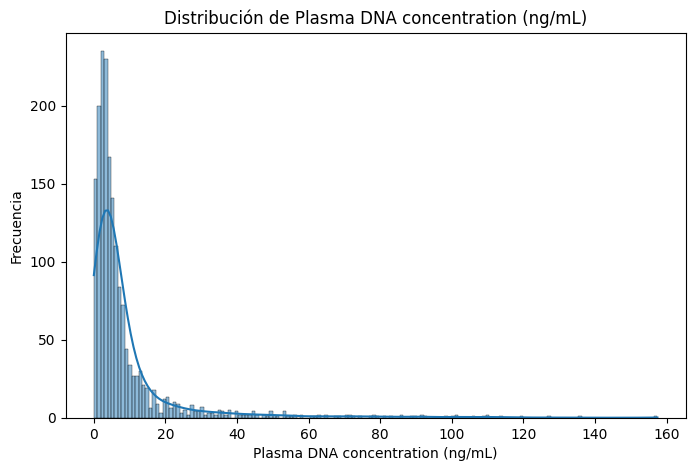

Asimetría de Plasma DNA concentration (ng/mL): 4.410391584967021
Curtosis de Plasma DNA concentration (ng/mL): 24.18446166778756


Prueba de Shapiro para Plasma DNA concentration (ng/mL): Estadística=0.501688539981842, p-valor=0.0
La distribución de Plasma DNA concentration (ng/mL) no parece normal


Prueba de normalidad alternativa para Plasma DNA concentration (ng/mL): Estadística=1664.1935951654164, p-valor=0.0
La distribución de Plasma DNA concentration (ng/mL) no parece normal




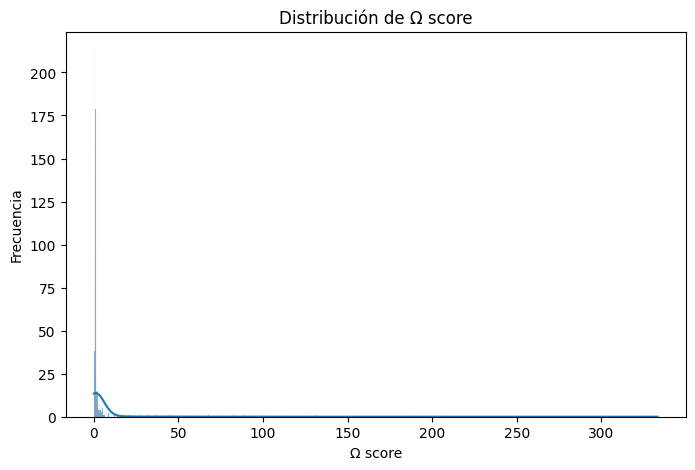

Asimetría de Ω score: nan
Curtosis de Ω score: nan


Prueba de Shapiro para Ω score: Estadística=nan, p-valor=1.0
La distribución de Ω score parece normal


Prueba de normalidad alternativa para Ω score: Estadística=nan, p-valor=nan
La distribución de Ω score no parece normal




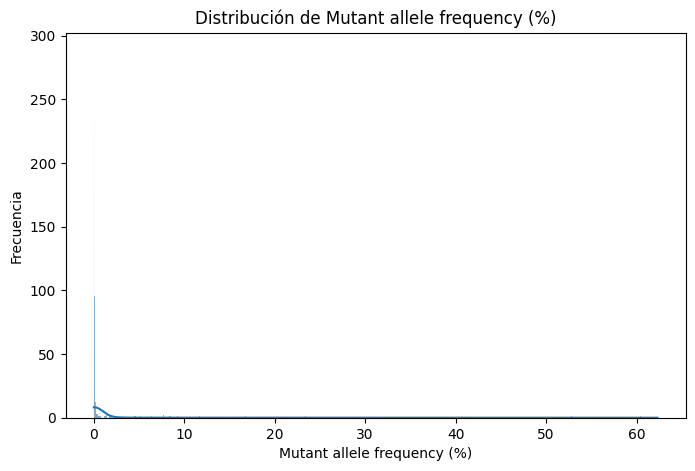

Asimetría de Mutant allele frequency (%): nan
Curtosis de Mutant allele frequency (%): nan


Prueba de Shapiro para Mutant allele frequency (%): Estadística=nan, p-valor=1.0
La distribución de Mutant allele frequency (%) parece normal


Prueba de normalidad alternativa para Mutant allele frequency (%): Estadística=nan, p-valor=nan
La distribución de Mutant allele frequency (%) no parece normal




Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x000002F3DCD63100>
Traceback (most recent call last):
  File "c:\Users\danie\.virtualenvs\Plantillas-rmuV9HM5\Lib\site-packages\matplotlib\transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))

KeyboardInterrupt: 


In [16]:
# Visualización de la distribución de las variables numéricas + verificación la ASIMETRÍA y la CURTOSIS de la distribución

# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df5
print("Distribución de las variables numéricas:")
num_cols = dataFrame.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(dataFrame[col], kde=True)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()
        
    # Verificar la asimetría y la curtosis de la distribución
    skewness = skew(dataFrame[col])
    kurt = kurtosis(dataFrame[col])
    print(f"Asimetría de {col}: {skewness}")
    print(f"Curtosis de {col}: {kurt}")
    print("\n")
        
    # Prueba de normalidad
    stat, p = shapiro(dataFrame[col])
    print(f"Prueba de Shapiro para {col}: Estadística={stat}, p-valor={p}")
    if p > 0.05:
        print(f"La distribución de {col} parece normal")
    else:
        print(f"La distribución de {col} no parece normal")
    print("\n")
        
    # Prueba de normalidad alternativa
    stat, p = normaltest(dataFrame[col])
    print(f"Prueba de normalidad alternativa para {col}: Estadística={stat}, p-valor={p}")
    if p > 0.05:
        print(f"La distribución de {col} parece normal")
    else:
        print(f"La distribución de {col} no parece normal")
    print("\n")

# 3. DEFINIENDO LAS FUNCIONES

In [43]:
# FUNCIONES
# Función de limpieza de datos total del dataFrame
def limpiar_datos(df):
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    """
    Realiza la limpieza de datos en un DataFrame, incluyendo imputación de valores faltantes, 
    escalado y codificación one-hot para variables categóricas.

    Args:
        df (pandas.DataFrame): El DataFrame que contiene los datos.

    Returns:
        pandas.DataFrame: El DataFrame con los datos limpios, escalados y codificados.
    """
    # Separar variables numéricas y categóricas
    df_numeric = df.select_dtypes(include=np.number)
    df_categorical = df.select_dtypes(exclude=np.number)
    
    # Imputación de valores faltantes para variables numéricas
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    
    # Escalado de variables numéricas
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)
    
    # Codificación one-hot para variables categóricas
    encoder = OneHotEncoder(drop='first', sparse=False)
    df_encoded = pd.DataFrame(encoder.fit_transform(df_categorical), columns=encoder.get_feature_names_out(df_categorical.columns))
    
    # Unir los DataFrames de variables numéricas escaladas y categóricas codificadas
    df_cleaned = pd.concat([df_scaled, df_encoded], axis=1)
    
    return df_cleaned

# Función para limpiar una columna particular pasada como parámetro a la función
def limpiar_columna(columna):
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    """
    Realiza la limpieza de datos para una columna específica del DataFrame, incluyendo imputación de valores faltantes 
    y escalado para variables numéricas, y codificación one-hot para variables categóricas.

    Args:
        df (pandas.DataFrame): El DataFrame que contiene los datos.
        columna (str): El nombre de la columna a limpiar.

    Returns:
        pandas.Series: La columna ya limpia.
    """
    # Verificar si la columna es numérica o categórica
    if pd.api.types.is_numeric_dtype(df[columna]):
        # Imputación de valores faltantes con la media
        imputer = SimpleImputer(strategy='mean')
        df[columna] = imputer.fit_transform(df[[columna]])
        
        # Escalado de datos
        scaler = StandardScaler()
        df[columna] = scaler.fit_transform(df[[columna]])
    else:
        # Imputación de valores faltantes con la moda
        imputer = SimpleImputer(strategy='most_frequent')
        df[columna] = imputer.fit_transform(df[[columna]])
        
        # Codificación one-hot para variables categóricas
        encoder = OneHotEncoder(drop='first', sparse=False)
        encoded_data = encoder.fit_transform(df[[columna]])
        column_names = encoder.get_feature_names_out([columna])
        df_encoded = pd.DataFrame(encoded_data, columns=column_names)
        
        # Eliminar la columna original y agregar las columnas codificadas
        df = pd.concat([df.drop(columns=[columna]), df_encoded], axis=1)
    
    return df[columna]

# ---------------------------------------------------------------------------------------------

# Función para eliminar filas y columnas (normalmente por carecer de datos suficientes)
# Eliminar filas con valores faltantes
def eliminar_filas_con_nulos(df, columna):
    return df.dropna(subset=[columna], inplace=True)

# Elimina la columna pasada como parámetro
def eliminar_col(columnName):
    df.drop(columns = columnName, inplace=True)
# --------------------------------------------------------------------

# Funciones para rellenar valores faltantes
# Rellenar con la media o la mediana (variables numéricas)
def fill_mean_or_median(columnName,value):
    if value == 'mean':
        df[columnName].fillna(df[columnName].mean(), inplace=True)
    elif value == 'median':
        df[columnName].fillna(df[columnName].median(), inplace=True)

# Rellenar con la moda (variables categóricas)
def fill_mode(columnName):
    df[columnName].fillna(df[columnName].mode().iloc[0], inplace=True)

# Rellenar valores faltantes con un valor específico (variables numéricas o categóricas)
def fill_with_value(columnName,value) :
    df[columnName].fillna(value=value, inplace=True)

# Rellenar valores faltantes con el valor siguiente (variables ordenadas en el tiempo)
def fill_with_forward(columnName):
    df[columnName].fillna(method='ffill', inplace=True)

# Rellenar valores faltantes con el valor anterior (variables ordenadas en el tiempo)
def fill_with_back(columnName):
    df[columnName].fillna(method='bfill', inplace=True)

# Interpolación lineal para rellenar valores faltantes (variables numéricas ordenadas)
def fill_with_interpolation(columnName) :
    df[columnName].interpolate(method='linear', inplace=True)

# 4. ACCIONES DE LIMPIEZA SOBRE LOS DATOS

La información total a tratar se almacena en la tabla S6, es decir, en el dataFrame df6.

Se hace una limpieza sobre la totalidad de los datos y luego se llevan a cabo dos divisiones:

- Obtención de los datos de todos los pacientes pero, exclusivamente de las 8 variables con mayor peso a la hora de la predicción de la existencia de cáncer.
- Obtención de los datos de los pacientes presentes en la tabla 8 con todas las variables de la tabla 6, siendo la variable objetivo el tipo de cáncer.

Al tratarse de cadenas de texto, se observa que bastantes registros contienen las cadenas de texto '*' y '**'. 

## 4.1 Conteo de caracteres no deseados '*' y '**'

In [23]:
# P
# Crear un diccionario para almacenar los conteos de cada columna
conteos = {}

# Definir las secuencias a buscar
secuencias_a_buscar = ['*', '**']

# Iterar sobre cada columna del DataFrame
for columna in df6.columns:
    # Inicializar el contador para esta columna
    conteo_columna = {secuencia: 0 for secuencia in secuencias_a_buscar}
    
    # Verificar si la columna es de tipo objeto (cadena)
    if df6[columna].dtype == 'object':
        # Iterar sobre cada elemento de la columna
        for elemento in df6[columna]:
            # Verificar si el elemento es una cadena
            if isinstance(elemento, str):
                # Contar la ocurrencia de cada secuencia en el elemento
                for secuencia in secuencias_a_buscar:
                    conteo_columna[secuencia] += elemento.count(secuencia)
    
    # Guardar los conteos para esta columna en el diccionario de conteos
    conteos[columna] = conteo_columna

# Imprimir los conteos
for columna, conteo_columna in conteos.items():
    print(f"Conteo de secuencias en columna '{columna}': {conteo_columna}")

Conteo de secuencias en columna 'Patient ID #': {'*': 0, '**': 0}
Conteo de secuencias en columna 'Sample ID #': {'*': 0, '**': 0}
Conteo de secuencias en columna 'Tumor type': {'*': 0, '**': 0}
Conteo de secuencias en columna 'AJCC Stage': {'*': 0, '**': 0}
Conteo de secuencias en columna 'AFP (pg/ml)': {'*': 1047, '**': 13}
Conteo de secuencias en columna 'Angiopoietin-2 (pg/ml)': {'*': 7, '**': 2}
Conteo de secuencias en columna 'AXL (pg/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'CA-125 (U/ml)': {'*': 1120, '**': 1}
Conteo de secuencias en columna 'CA 15-3 (U/ml)': {'*': 20, '**': 8}
Conteo de secuencias en columna 'CA19-9 (U/ml)': {'*': 1272, '**': 1}
Conteo de secuencias en columna 'CD44 (ng/ml)': {'*': 55, '**': 0}
Conteo de secuencias en columna 'CEA (pg/ml)': {'*': 234, '**': 4}
Conteo de secuencias en columna 'CYFRA 21-1 (pg/ml)': {'*': 1373, '**': 1}
Conteo de secuencias en columna 'DKK1 (ng/ml)': {'*': 33, '**': 0}
Conteo de secuencias en columna 'Endoglin (pg/

## 4.2 Eliminación de los caracteres no deseados

Se procede por tanto a eliminar dichas cadenas.

In [24]:
# P
# Definir las secuencias a buscar
secuencias_a_buscar = ['*', '**']

# Crear una copia del DataFrame original para realizar los cambios
df6_prep = df6.copy()

# Recorrer las columnas del DataFrame
for columna in df6_prep.columns:
    if df6_prep[columna].dtype == 'object':
        # Aplicar la sustitución para cada secuencia en secuencias_a_buscar
        for secuencia in secuencias_a_buscar:
            df6_prep[columna] = df6_prep[columna].apply(lambda x: x.replace(secuencia, '') if isinstance(x, str) and secuencia in x else x)

Verificamos si se han borrado correctamente las cadenas de texto

In [25]:
# P
# Crear un diccionario para almacenar los conteos de cada columna
conteos = {}

# Definir las secuencias a buscar
secuencias_a_buscar = ['*', '**']

# Iterar sobre cada columna del DataFrame
for columna in df6_prep.columns:
    # Inicializar el contador para esta columna
    conteo_columna = {secuencia: 0 for secuencia in secuencias_a_buscar}
    
    # Verificar si la columna es de tipo objeto (cadena)
    if df6_prep[columna].dtype == 'object':
        # Iterar sobre cada elemento de la columna
        for elemento in df6_prep[columna]:
            # Verificar si el elemento es una cadena
            if isinstance(elemento, str):
                # Contar la ocurrencia de cada secuencia en el elemento
                for secuencia in secuencias_a_buscar:
                    conteo_columna[secuencia] += elemento.count(secuencia)
    
    # Guardar los conteos para esta columna en el diccionario de conteos
    conteos[columna] = conteo_columna

# Imprimir los conteos
for columna, conteo_columna in conteos.items():
    print(f"Conteo de secuencias en columna '{columna}': {conteo_columna}")

Conteo de secuencias en columna 'Patient ID #': {'*': 0, '**': 0}
Conteo de secuencias en columna 'Sample ID #': {'*': 0, '**': 0}
Conteo de secuencias en columna 'Tumor type': {'*': 0, '**': 0}
Conteo de secuencias en columna 'AJCC Stage': {'*': 0, '**': 0}
Conteo de secuencias en columna 'AFP (pg/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'Angiopoietin-2 (pg/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'AXL (pg/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'CA-125 (U/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'CA 15-3 (U/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'CA19-9 (U/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'CD44 (ng/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'CEA (pg/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'CYFRA 21-1 (pg/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'DKK1 (ng/ml)': {'*': 0, '**': 0}
Conteo de secuencias en columna 'Endoglin (pg/ml)': {'*': 0, '**

## 4.3 Cambio del tipo de las variables

Cambiar a tipo numeric las variables de marcadores sanguíneos que sean de tipo Object

In [ ]:
print(df6_prep.dtypes)

In [26]:
# P
# Definir función para convertir a numérico manejando casos con letras
def convert_to_numeric(column):
    if column.dtype == 'object':
        # Verificar si hay letras en todos los registros
        contains_letters = any(isinstance(val, str) and any(c.isalpha() for c in val) for val in column)
        if contains_letters:
            print(f"La columna '{column.name}' contiene datos con letras. No se convierte a tipo numérico.")
        else:
                # Filtrar caracteres no numéricos y convertir a numérico
                # numeric_values = column.str.replace(r'[^0-9\.]', '', regex=True)
            # Intentar convertir a numérico, ignorando errores
            return pd.to_numeric(column, errors='coerce')
    return column

df6_prep = df6_prep.apply(convert_to_numeric)
print(df6_prep.dtypes)

La columna 'Patient ID #' contiene datos con letras. No se convierte a tipo numérico.
La columna 'Sample ID #' contiene datos con letras. No se convierte a tipo numérico.
La columna 'Tumor type' contiene datos con letras. No se convierte a tipo numérico.
La columna 'AJCC Stage' contiene datos con letras. No se convierte a tipo numérico.
La columna 'CancerSEEK Test Result' contiene datos con letras. No se convierte a tipo numérico.
Patient ID #                             object
Sample ID #                              object
Tumor type                               object
AJCC Stage                               object
AFP (pg/ml)                             float64
Angiopoietin-2 (pg/ml)                  float64
AXL (pg/ml)                             float64
CA-125 (U/ml)                           float64
CA 15-3 (U/ml)                          float64
CA19-9 (U/ml)                           float64
CD44 (ng/ml)                            float64
CEA (pg/ml)                          

## 4.4 Tratamiento valores nulos

Se han detectado también ciertos valores NaN en las muestras.


In [ ]:
plt.figure(figsize=(24, 16))
plt.title(f"HEATMAP de valores nulos para el dataFrame df6")
sns.heatmap(df6_prep.isnull(), cbar=False, yticklabels=False,cmap='plasma')

### 4.4.1 Enfoque 1 - Relleno mediante la media

ENFOQUE 1 : rellenar los valores nulos con la media de la muestra.
Se excluirán las columnas no numéricas.

In [31]:
# Calcular la media solo para las columnas numéricas
numeric_columns = df6_prep.select_dtypes(include=['number'])
mean_values = numeric_columns.mean()

# Rellenar los valores nulos con la media correspondiente
df6_prep_null_media = df6_prep.copy()  # Copiar el DataFrame original para evitar modificarlo
for col in mean_values.index:
    df6_prep_null_media[col].fillna(mean_values[col], inplace=True)


Comprobamos que se han rellenado los valores correctamente :

<Axes: title={'center': 'HEATMAP de valores nulos para el dataFrame df6'}>

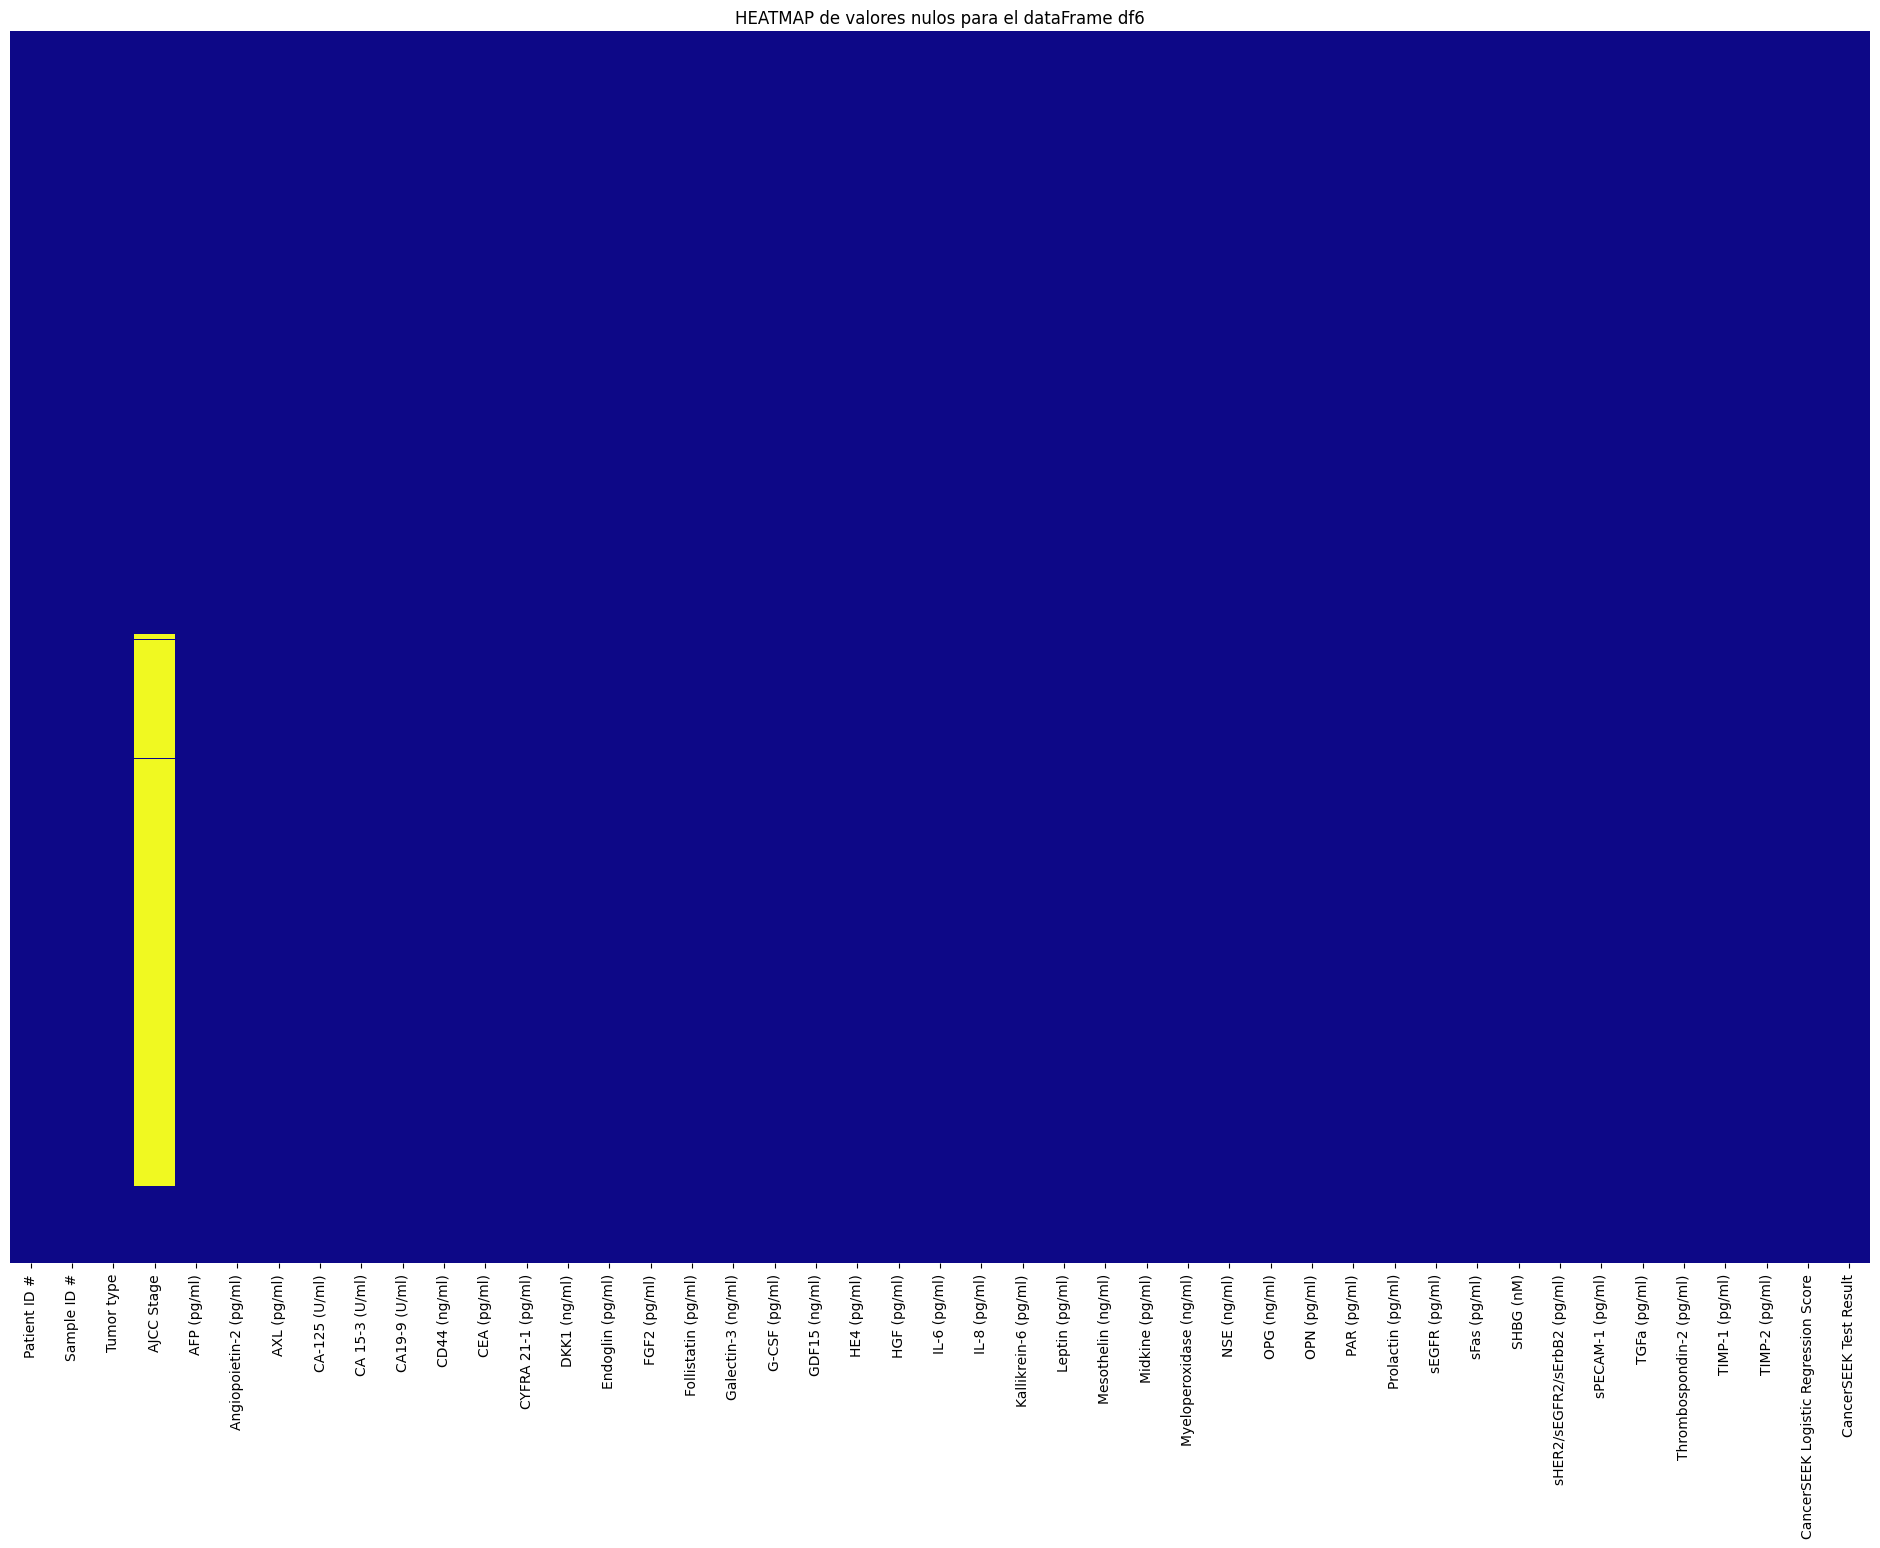

In [32]:
plt.figure(figsize=(24, 16))
plt.title(f"HEATMAP de valores nulos para el dataFrame df6")
sns.heatmap(df6_prep_null_media.isnull(), cbar=False, yticklabels=False,cmap='plasma')

### 4.4.2 Enfoque 2 - Relleno mediante predicción de valores usando KNN

In [38]:
from sklearn.impute import KNNImputer

# Separar las columnas numéricas de las categóricas
numeric_columns = df6_prep.select_dtypes(include=['number'])

# Imputar los valores faltantes utilizando KNN
imputer = KNNImputer(n_neighbors=2)  # Puedes ajustar el número de vecinos según sea necesario
imputed_values = imputer.fit_transform(numeric_columns)

# Reemplazar los valores imputados en el DataFrame original
df6_prep_null_KNN = pd.DataFrame(imputed_values, columns=numeric_columns.columns)

# Concatenar las columnas categóricas
for col in df6_prep.columns:
    if col not in numeric_columns.columns:
        df6_prep_null_KNN[col] = df6_prep[col]

In [ ]:
plt.figure(figsize=(24, 16))
plt.title(f"HEATMAP de valores nulos para el dataFrame df6")
sns.heatmap(df6_prep_null_KNN.isnull(), cbar=False, yticklabels=False,cmap='plasma')

In [47]:
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
# Separar las columnas numéricas de las categóricas
numeric_columns = df6_prep.select_dtypes(include=['number'])

# Método de imputación con KNN
imputer_knn = KNNImputer(n_neighbors=2)
imputed_values_knn = imputer_knn.fit_transform(numeric_columns)
df_imputed_knn = pd.DataFrame(imputed_values_knn, columns=numeric_columns.columns)

# Método de imputación con regresión lineal
df_imputed_linear = df6_prep.copy()  # Copiar el DataFrame original para evitar modificarlo
for col in numeric_columns.columns:
    complete_data = numeric_columns.dropna(subset=[col])
    missing_data = numeric_columns[col][numeric_columns[col].isnull()]
    
    if not missing_data.empty:
        # Eliminar filas con NaN de la matriz de características X
        X = complete_data.drop(columns=[col])
        y = complete_data[col]
        
        # Verificar si X contiene NaN
        if X.isnull().values.any():
            continue  # Saltar esta columna si X contiene NaN
        
        # Entrenar el modelo de regresión lineal
        imputer_linear = LinearRegression()
        imputer_linear.fit(X, y)
        
        # Predecir los valores faltantes
        predicted_values = imputer_linear.predict(missing_data.drop(columns=[col]).values.reshape(-1, 1))
        
        # Rellenar los valores faltantes
        df_imputed_linear.loc[missing_data.index, col] = predicted_values.flatten()


# Método de imputación con árbol de decisión
df_imputed_tree = df6_prep.copy()  # Copiar el DataFrame original para evitar modificarlo

for col in numeric_columns.columns:
    complete_data = numeric_columns.dropna(subset=[col])
    missing_data = numeric_columns[col][numeric_columns[col].isnull()]
    
    if not missing_data.empty:
        # Eliminar filas con NaN de la matriz de características X
        X = complete_data.drop(columns=[col])
        y = complete_data[col]
        
        # Verificar si X contiene NaN
        if X.isnull().values.any():
            continue  # Saltar esta columna si X contiene NaN
        
        # Entrenar el modelo de árbol de decisión
        imputer_tree = DecisionTreeRegressor()
        imputer_tree.fit(X, y)
        
        # Predecir los valores faltantes
        predicted_values = imputer_tree.predict(missing_data.drop(columns=[col]))
        
        # Rellenar los valores faltantes
        df_imputed_tree.loc[missing_data.index, col] = predicted_values

# Combinar los DataFrames en uno solo
df_combined = pd.concat([df_imputed_knn, df_imputed_linear, df_imputed_tree], axis=1)

print("DataFrame con valores faltantes imputados comparados:")
print(df_combined)

DataFrame con valores faltantes imputados comparados:
      AFP (pg/ml)  Angiopoietin-2 (pg/ml)  AXL (pg/ml)  CA-125 (U/ml)  \
0        1583.450                 5598.50      3621.04          5.090   
1         715.308                20936.35      2772.96          7.270   
2        4365.530                 2350.93      4120.77          4.854   
3         715.308                 1604.34      2029.96          5.390   
4         801.300                 2087.57      2069.17          4.854   
...           ...                     ...          ...            ...   
1812      879.498                 1484.70      2096.76         24.820   
1813     1337.330                 1607.90       852.37          5.580   
1814      879.498                 1592.84      1044.45         30.480   
1815      879.498                 5267.95      1445.69       1469.450   
1816      879.498                 3546.43      1493.32       1428.310   

      CA 15-3 (U/ml)  CA19-9 (U/ml)  CD44 (ng/ml)  CEA (pg/ml)  \
0  

### 4.4.2 Enfoque 2 - Relleno mediante predicción de valores usando arboles de decisión

ENFOQUE 2 : rellenar los valores nulos con predicciones en base al resto de variables mediante un árbol de decisión.

Se intentará excluir las columnas que no aporten valor o peso en la predicción. Para ello se hace uso de la matriz de correlación.

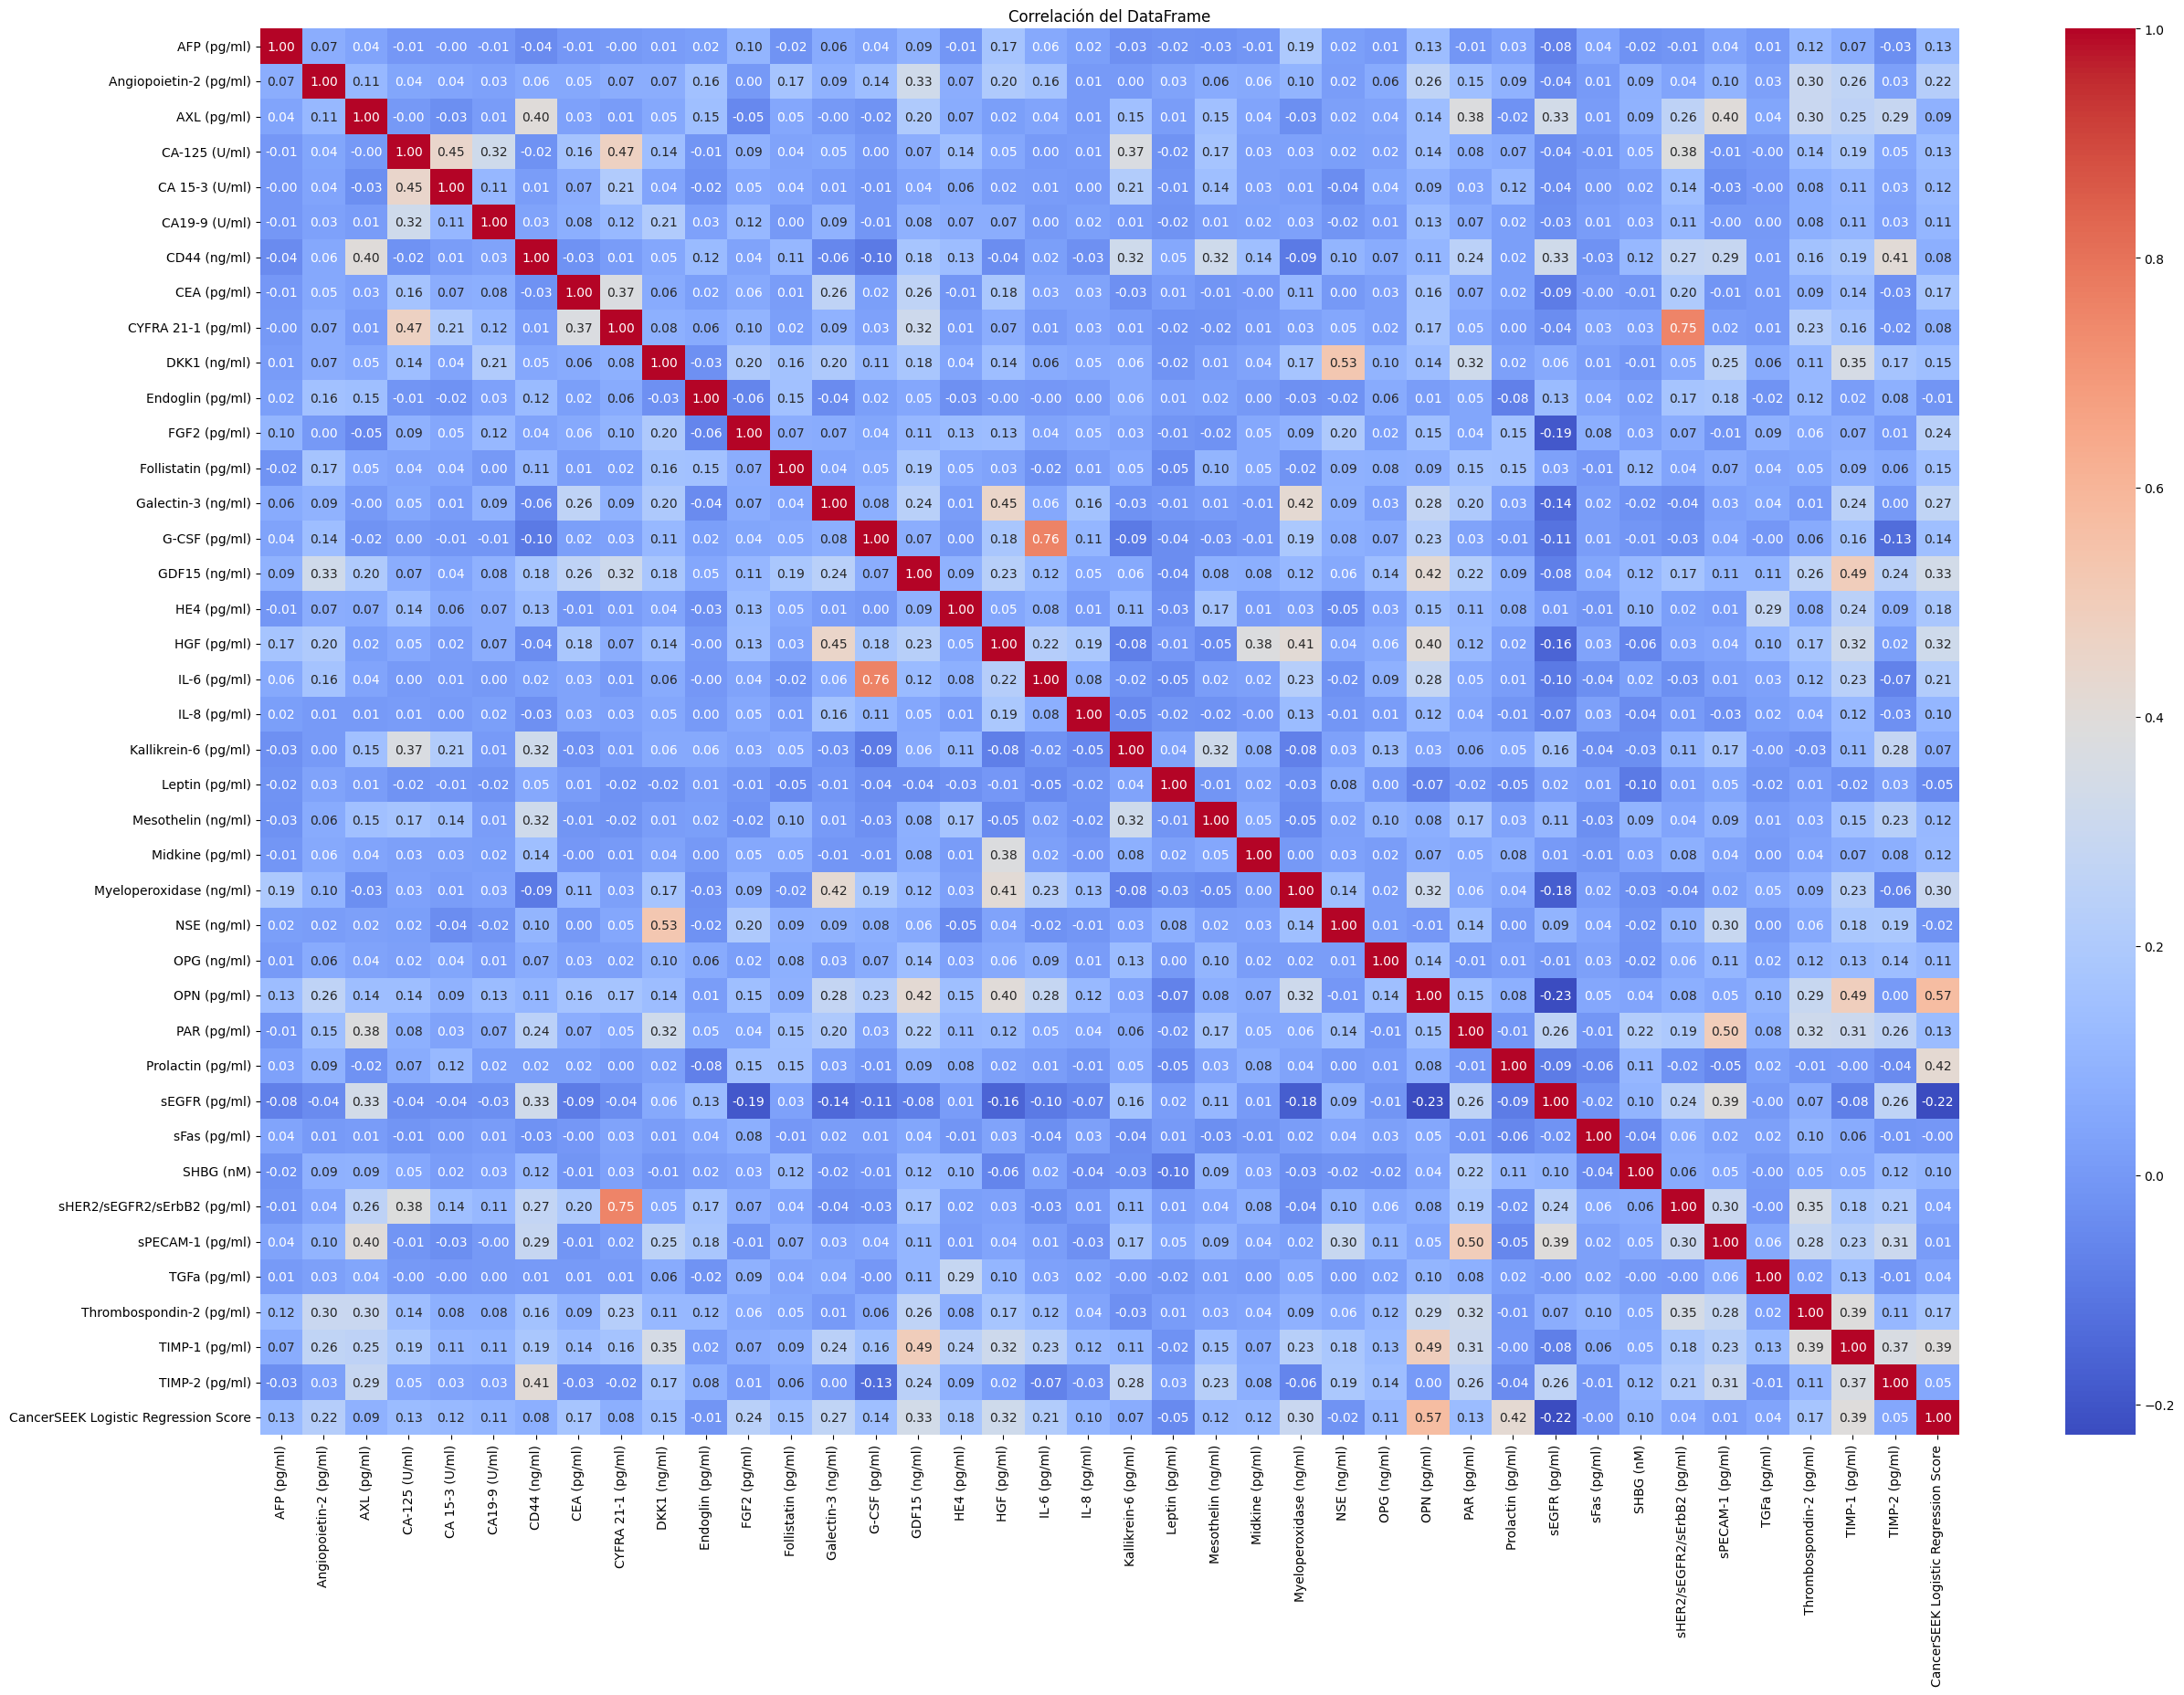

In [ ]:
# P
# Visualización de la correlación entre variables NUMÉRICAS
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df6_prep
numeric_correlation_matrix = dataFrame.select_dtypes(include=np.number).corr()
plt.figure(figsize=(30, 20))
sns.heatmap(numeric_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación del DataFrame')
plt.show()

_______________________________________

ENFOQUE 2 : rellenar los valores nulos con predicciones en base al resto de variables mediante un árbol de decisión.

Se intentará excluir las columnas que no aporten valor o peso en la predicción. Para ello se hace uso de la matriz de correlación.

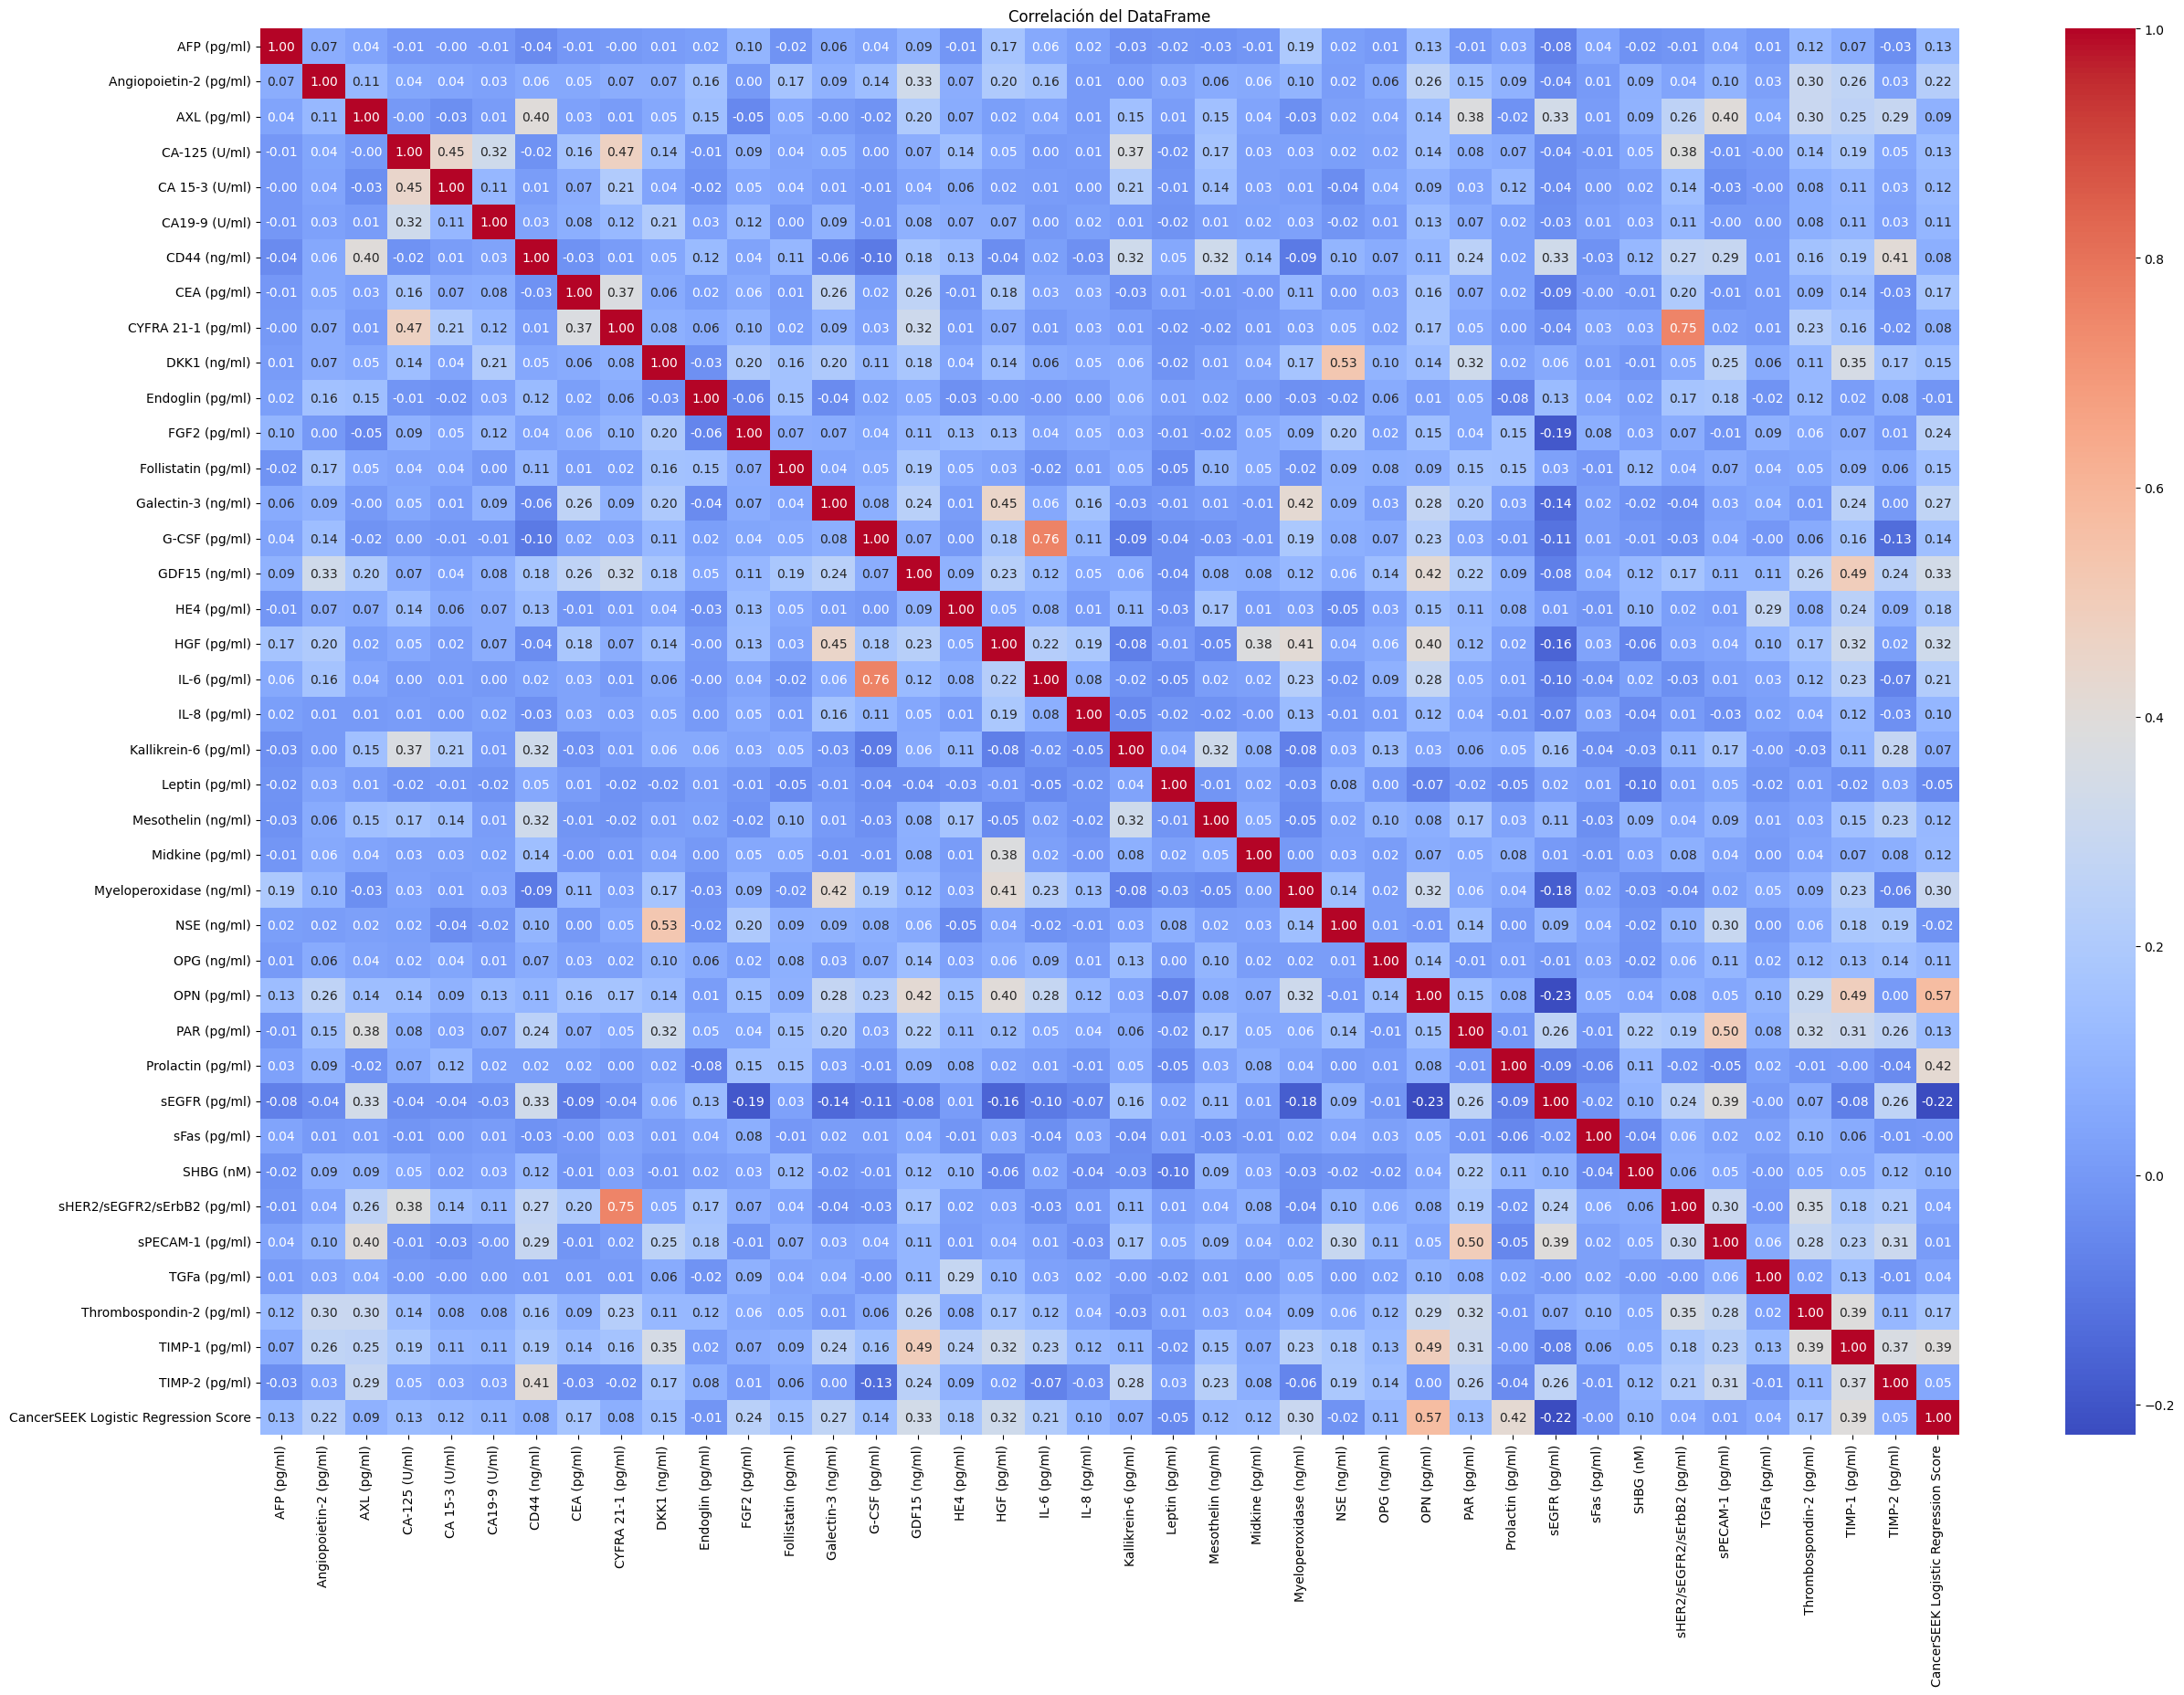

In [29]:
# P
# Visualización de la correlación entre variables NUMÉRICAS
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df6_prep
numeric_correlation_matrix = dataFrame.select_dtypes(include=np.number).corr()
plt.figure(figsize=(30, 20))
sns.heatmap(numeric_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación del DataFrame')
plt.show()

_______________________________________

## 4.5 Discretizar variables numéricas

[DUDA - Cambiar a numérico y luego aplicar MDL?]

En el estudio CancerA1DE, se aplica el principio MDL (Minimum Description Length), basado en la idea de que el mejor modelo es aquel que minimiza la longitud de la descripción del conjunto de datos, teniendo en cuenta tanto la capacidad de ajuste del modelo como la simplicidad del mismo. 
Por tanto, trata de encontrar la mejor manera de dividir los valores de una característica continua en intervalos discretos o categorías.

Ejecutar el principio de MDL para discretizar las muestras de las variables

- Se inicializa la JVM de Weka.
- Se carga el conjunto de datos ARFF.
- Se configura el filtro de selección de características utilizando ASSearch para buscar las mejores características utilizando el algoritmo BestFirst y ASEvaluation para evaluar la ganancia de información.
- Se aplica el filtro de selección de características al conjunto de datos.
- Se entrena un clasificador J48 utilizando las características seleccionadas.
- Se evalúa el modelo utilizando validación cruzada de 10 pliegues.
- Finalmente, se imprime un resumen de la evaluación.

In [35]:
## TO DO

In [ ]:
# pip install weka

import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.attribute_selection import ASSearch, ASEvaluation, AttributeSelection
from weka.classifiers import Classifier, Evaluation
from weka.classifiers import FilteredClassifier
from weka.filters import Filter

# Inicializar JVM de Weka
jvm.start()

# Cargar el conjunto de datos
data = df6_prep
data.class_is_last()

# Crear el filtro de selección de características
search = ASSearch(classname="weka.attributeSelection.BestFirst", options=["-D", "1", "-N", "5"])
evaluation = ASEvaluation(classname="weka.attributeSelection.InfoGainAttributeEval")
selector = AttributeSelection()
selector.search(search)
selector.evaluator(evaluation)
selector.select_attributes(data)

# Obtener el índice de las características seleccionadas
selected_attributes = selector.selected_attributes()

# Crear el clasificador
classifier = Classifier(classname="weka.classifiers.trees.J48")

# Combinar el clasificador con el filtro de selección de características
filtered_classifier = FilteredClassifier()
filtered_classifier.filter(selector)
filtered_classifier.classifier(classifier)

# Evaluar el modelo
evaluation = Evaluation(data)
evaluation.crossvalidate_model(filtered_classifier, data, 10, Random(1))
print(evaluation.summary())


Una vez aplicado el principio de MDL se muestran en histogramas las variables discretizadas

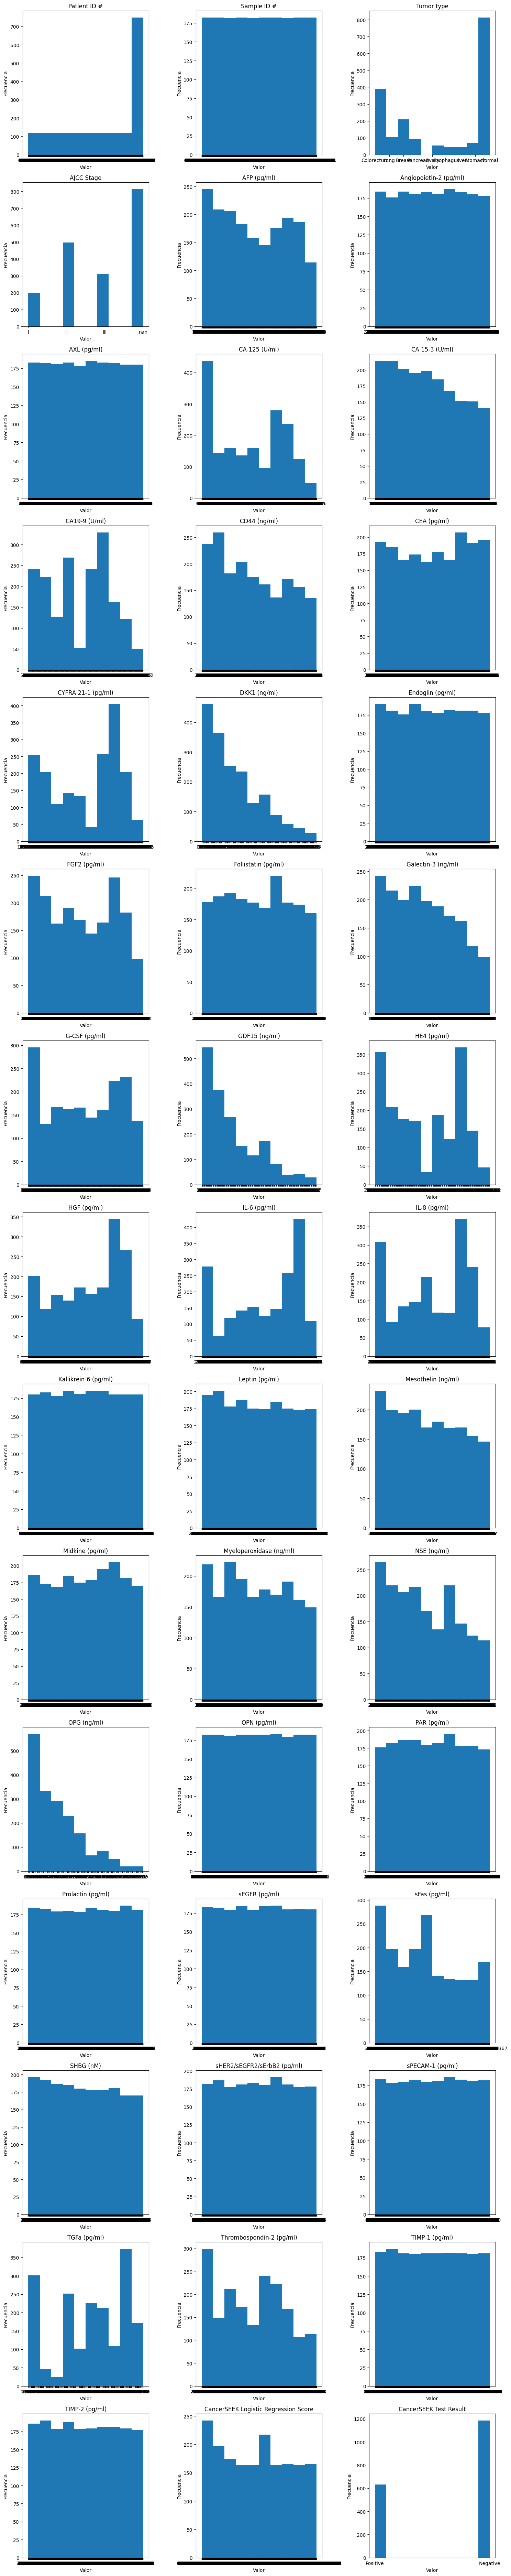

In [36]:
# Definir el número de histogramas por fila
histogramas_por_fila = 3

# Obtener el número total de variables y calcular el número total de filas necesarias
num_variables = len(df6_prep_null_media.columns)
num_filas = (num_variables + histogramas_por_fila - 1) // histogramas_por_fila

# Crear una figura y ejes para subplots
fig, axs = plt.subplots(num_filas, histogramas_por_fila, figsize=(15, 5*num_filas))

# Iterar sobre cada variable y dibujar su histograma en un subplot
for i, columna in enumerate(df6_prep_null_media.columns):
    fila = i // histogramas_por_fila
    columna_subplot = i % histogramas_por_fila
    
    # Convertir los valores flotantes en cadenas
    datos_columna = df6_prep_null_media[columna].astype(str)
    
    axs[fila, columna_subplot].hist(datos_columna, bins=10)  # Puedes ajustar el número de bins si lo deseas
    axs[fila, columna_subplot].set_title(columna)
    axs[fila, columna_subplot].set_xlabel('Valor')
    axs[fila, columna_subplot].set_ylabel('Frecuencia')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

In [ ]:
# TOMAR ACCIONES DE LIMPIEZA SOBRE LOS DATOS

'''
# Eliminar los datos duplicados
 df = df.drop_duplicates()

# Aplicar las funciones de limpieza según el tipo de datos
for col_name in df.columns:
    if data_types[col_name] == np.number: # si la columna es numérica
        df[col_name] = clean_numeric(df[col_name]) # aplicar la función clean_numeric
    elif data_types[col_name] == np.object: # si la columna es categórica
        df[col_name] = clean_categorical(df[col_name]) # aplicar la función clean_categorical
    else:
        pass # si la columna es de otro tipo, no hacer nada

# Imputar los valores que faltan
df = df.fillna(df.mode().iloc[0]) # reemplazar los valores nulos por la moda de cada columna

# Consolidar los datos
df = df.merge(df2, on="id") # unir el dataset con otro dataset usando la columna id como clave
df = df.groupby("categoria").agg({"precio": "mean", "calificacion": "max"}) # agrupar el dataset por la columna categoria y calcular la media del precio y el máximo de la calificacion

# Explorar los datos
df.describe() # obtener un resumen estadístico de las columnas numéricas
df["categoria"].value_counts() # obtener la frecuencia de cada valor en la columna categoria
df.corr() # obtener la matriz de correlación entre las columnas numéricas
df.plot(kind="scatter", x="precio", y="calificacion") # crear un gráfico de dispersión entre las columnas precio y calificacion

'''

# 5. OBTENCION DEL TRAIN SET

In [45]:
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df4
print(dataFrame.info())
df4_processed = limpiar_datos(dataFrame)
print(df4_processed.info())
# df4_processed.drop(columns=[''])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Patient ID #                          1817 non-null   object 
 1   Plasma sample ID #                    1817 non-null   object 
 2   Primary tumor sample ID #             1817 non-null   object 
 3   Age                                   1817 non-null   float64
 4   Sex                                   1817 non-null   object 
 5   Race                                  1817 non-null   object 
 6   Tumor type                            1817 non-null   object 
 7   AJCC Stage                            1005 non-null   object 
 8   Histopathology                        1005 non-null   object 
 9   Plasma volume (mL)                    1817 non-null   float64
 10  Plasma DNA concentration (ng/mL)      1817 non-null   float64
 11  CancerSEEK Logist

c:\Users\danie\.virtualenvs\Plantillas-rmuV9HM5\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Columns: 4473 entries, Age to CancerSEEK Test Result_Positive
dtypes: float64(4473)
memory usage: 62.0 MB
None


In [41]:
# (I) Introducir valor de dataFrame [df1, df2, df3, ... , df9]
dataFrame = df4
print(df4.head())
df4_tmp = df.drop()
# (I) Introducir valor de variableAPredecir
'''variableAPredecir = 'variableAPredecir'
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(variableAPredecir, axis = 'columns'),
                                        df[variableAPredecir],
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle      = True
                                    )
                                    '''

  Patient ID # Plasma sample ID # Primary tumor sample ID #        Age  \
0      CRC 455      CRC 455 PLS 1             Not available  59.811088   
1      CRC 456      CRC 456 PLS 1               CRC 456 PT1  59.091034   
2      CRC 457      CRC 457 PLS 1               CRC 457 PT1  68.618754   
3      CRC 458      CRC 458 PLS 1               CRC 458 PT1  69.563313   
4      CRC 459      CRC 459 PLS 1               CRC 459 PT1  43.359343   

      Sex       Race  Tumor type AJCC Stage  Histopathology  \
0    Male  Caucasian  Colorectum          I  Adenocarcinoma   
1  Female  Caucasian  Colorectum          I  Adenocarcinoma   
2  Female  Caucasian  Colorectum         II  Adenocarcinoma   
3  Female  Caucasian  Colorectum         II  Adenocarcinoma   
4  Female  Caucasian  Colorectum         II  Adenocarcinoma   

   Plasma volume (mL)  Plasma DNA concentration (ng/mL)  \
0                 5.0                          6.079696   
1                 4.0                         46.005220   

"variableAPredecir = 'variableAPredecir'\nX_train, X_test, y_train, y_test = train_test_split(\n                                        df.drop(variableAPredecir, axis = 'columns'),\n                                        df[variableAPredecir],\n                                        train_size   = 0.8,\n                                        random_state = 42,\n                                        shuffle      = True\n                                    )\n                                    "

# 6. ESTANDARIZACIÓN/NORMALIZACIÓN DE LAS COLUMNAS NUMÉRICAS Y BINARIZACION DE LAS VARIABLES CATEGÓRICAS

Cuando los predictores son numéricos, la escala en la que se miden, así como la magnitud de su **varianza** pueden influir en gran medida en el modelo. Muchos algoritmos de machine learning (SVM, redes neuronales, lasso...) son sensibles a esto, de forma que, si no se igualan de alguna forma los predictores, aquellos que se midan en una escala mayor o que tengan más varianza dominarán el modelo aunque no sean los que más relación tienen con la variable respuesta.

**Normalización** (estandarización): consiste en transformar los datos de forma que todos los predictores estén aproximadamente en la misma escala. 

    Hay dos formas de lograrlo:
    - Normalización Z-score (`StandardScaler`): dividir cada predictor entre su desviación típica después de haber sido centrado, de esta forma, los datos pasan a tener una distribución normal.
    - Estandarización max-min (`MinMaxScaler`): transformar los datos de forma que estén dentro del rango `[0, 1]`.

**Binarización de las variables cualitativas :**

    La binarización (*one-hot-encoding*) consiste en crear nuevas variables *dummy* con cada uno de los niveles de las variables cualitativas.

In [ ]:
# Selección de las variables por tipo
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

X_train_prep.head(3)

# 7. CREACIÓN DEL MODELO

El siguiente paso tras definir los datos de entrenamiento, es seleccionar el algoritmo que se va a emplear. En **scikit-learn**, esto se hace mediante la creación de un objeto `estimator`. En concreto, este objeto almacena el nombre del algoritmo, sus parámetros e hiperparámetros y contiene los métodos `fit(X, y)` y `predict(y_)` que le permiten aprender de los datos y predecir nuevas observaciones.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train_prep, y_train)

# 8. VALIDACIÓN

La finalidad última de un modelo es predecir la variable respuesta en observaciones futuras o en observaciones que el modelo no ha "visto" antes. El error mostrado por defecto tras entrenar un modelo suele ser el error de entrenamiento, el error que comete el modelo al predecir las observaciones que ya ha "visto". Si bien estos errores son útiles para entender cómo está aprendiendo el modelo (estudio de residuos), no es una estimación realista de cómo se comporta el modelo ante nuevas observaciones (el error de entrenamiento suele ser demasiado optimista). Para conseguir una estimación más certera, y antes de recurrir al conjunto de **test**, se pueden emplear estrategias de validación basadas en resampling. **Scikit-learn** incorpora en el módulo `sklearn.model_selection` varias estrategias de validación.

Todas ellas reciben como primer argumento un estimator que puede ser directamente un *modelo* o un *pipeline*.

Las métricas de error de regresión se devuelven siempre en negativo de forma que, cuanto más próximo a 0 sea el valor, mejor el ajuste. Esto es así para que, los procesos de optimización siempre sean de maximización.

La forma más sencilla es emplear la función `cross_val_score()`, que utiliza por defecto `KFold`.

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = model,
                X         = X_train_prep,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

# 9. Predicción

Una vez que el modelo ha sido entrenado, bien empleando directamente un *estimator* o un *pipeline*, con el método `.predict()` se pueden predecir nuevas observaciones. Si se emplea un pipeline, se aplican automáticamente las transformaciones aprendidas durante el entrenamiento.

In [ ]:
predicciones = model.predict(X_test_prep)

# Se crea un dataframe con las predicciones y el valor real
df_predicciones = pd.DataFrame({'precio' : y_test, 'prediccion' : predicciones})
df_predicciones.head()

# 10. Error del test
El módulo `sklearn.metrics` incorpora una variedad considerable de métricas para evaluar la calidad de las predicciones.

In [ ]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
rmse

# 11. INTERPRETACIÓN

# EXTRAS

---


**Texto en negrita**

*Texto en cursiva*

~~Texto tachado~~, pero este no está tachado

---
<font color="#004D7F" size=6 style="font-family:Verdana;">Enlaces</font>

[Texto del enlace](https://www.example.com)

[Ancla a parte del código (título Markdown)](#bloque2)

![Imagen de Kschool](https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png)

Opción 2

<center><img src="https://nachocarnes.es/wp-content/uploads/2018/04/ejWGXui6_400x400.png" alt="Drawing" style="align=left"/>

In [ ]:
!git clone https://github.com/emunozlorenzo/DataCopCrimePrediction.git

Cloning into 'DataCopCrimePrediction'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 367 (delta 55), reused 58 (delta 30), pack-reused 271
Receiving objects: 100% (367/367), 14.71 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (188/188), done.


#### **Aquí os añado la referencia a una pagina donde podéis encontrar muchos más ejemplos:**
1. https://daringfireball.net/projects/markdown/basics
2. https://programmerclick.com/article/9139292621/